# U-Net Training Experiment

## Notebook Setup

### Mount Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_drive = "/content/gdrive/My\ Drive"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = root_drive + '/Learning/UCI-274P/Project/'

In [0]:
#change directory to path
% cd {path}

/content/gdrive/My Drive/Learning/UCI-274P/Project


### Import Libraries

In [0]:
from torch.utils.data import DataLoader
from torch import optim 
import torch.nn as nn
import torch

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd

from loader import cityscapesDataset
from models import unet

### CUDA Setup

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
def print_free_memory():
  t = torch.cuda.get_device_properties(0).total_memory
  torch.cuda.empty_cache()
  c = torch.cuda.memory_cached(0)
  a = torch.cuda.memory_allocated(0)
  f = c-a  # free inside cache
  print('Total CUDA: ',t/(1024*1024*1024),' GB Free space: ',f/(1024*1024) ," MB")
  return

This is a method to  save the model

In [0]:
savefolder = "./saves/exp1/"
startEpoch = 0

def saveState(filename, epoch, model, optimizer, loss):
  savefile = savefolder + filename + str(epoch) + ".pth"
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, savefile)
  return


## Load dataset images to Custom Dataset Object

In [0]:
cd_tr = cityscapesDataset.CityscapesDataset("./Cityscapes", split='train', target_type='semantic', cropHeight=256, cropWidth=512)
cd_val = cityscapesDataset.CityscapesDataset("./Cityscapes", split='val', target_type='semantic')

In [0]:
img, lbl = cd_val[0]
img.shape

torch.Size([3, 1024, 2048])

### Create Learner

In [0]:
learner = unet.UNet(3, cd_tr.n_classes).to(device=device)

### Hyper parameters

In [0]:
bs = 16
n_workers=0
n_epochs = 30
lr = 0.00003
mom=0.9# Not used
wd = 0.01

### Create Data Loader

In [0]:
dl_train = DataLoader(cd_tr, batch_size=bs, num_workers=n_workers, shuffle=True, pin_memory=True) 
dl_val = DataLoader(cd_val, batch_size=1, num_workers=n_workers, shuffle=True, pin_memory=True)
val_iter = iter(dl_val)

## Experiment 1 - Training using Adam and CrossEntropyLoss

In [0]:
optimizer = optim.Adam(learner.parameters(), lr=lr, weight_decay=wd)
criterion = nn.CrossEntropyLoss(ignore_index=cd_tr.ignore_index)

In [0]:
print_free_memory()

Total CUDA:  11.17303466796875  GB Free space:  13.42724609375  MB


In [0]:
savefile=savefolder+"save60.pth"

In [0]:
checkpoint = torch.load(savefile)
learner.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
startEpoch = checkpoint['epoch']
loss = checkpoint['loss']
print("Epoch ",startEpoch," Loaded.")

Epoch  60  Loaded.


### Training Loop

In [0]:
# help from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
losses_tr=[]
losses_val=[]
for epoch in tqdm(range(n_epochs)):
    learner.train()
    train_epoch_loss = 0
    val_epoch_loss=0
    i=0
    for imgs, lbls in dl_train:
        
        imgs = imgs.to(device=device)
        lbls = lbls.to(device=device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
    
        #forward
        pred = learner(imgs)
        
        #shrink labels for nn.CrossEntropy
        lbls = lbls.squeeze(dim=1)
        loss = criterion(pred, lbls)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()

        del imgs, lbls, pred
        torch.cuda.empty_cache()

        i+=1
        print("Train Iter: ", i," Loss: ", train_epoch_loss/i)

    saveState("save", startEpoch+1+epoch, learner, optimizer, loss)
    
    # i=0
    with torch.no_grad():
      learner.eval()
      
      imgs, lbls = val_iter.next()
      
      imgs = imgs.to(device=device)
      lbls = lbls.to(device=device)

      pred = learner(imgs)
      lbls = lbls.squeeze(dim=1)
      loss = criterion(pred, lbls)
      val_epoch_loss = loss.item()
    print("Val Iter: Loss: ", val_epoch_loss)
      
    losses_tr.append(train_epoch_loss/len(dl_train))
    losses_val.append(val_epoch_loss)
    
    print("Epoch {}, Mean Train Loss: {}, Val Loss (1 sample): {}".format(epoch, losses_tr[-1],  losses_val[-1]))

    

Streaming output truncated to the last 5000 lines.
Train Iter:  79  Loss:  1.3101830127872998
Train Iter:  80  Loss:  1.3091618411242962
Train Iter:  81  Loss:  1.3077242293475586
Train Iter:  82  Loss:  1.3055364424135627
Train Iter:  83  Loss:  1.3145404759659824
Train Iter:  84  Loss:  1.3173195712623142
Train Iter:  85  Loss:  1.3173883459147284
Train Iter:  86  Loss:  1.3150533610998199
Train Iter:  87  Loss:  1.315201232488128
Train Iter:  88  Loss:  1.3170169232921167
Train Iter:  89  Loss:  1.3135996862743677
Train Iter:  90  Loss:  1.3103956149684057
Train Iter:  91  Loss:  1.3097714480462965
Train Iter:  92  Loss:  1.3116806985243508
Train Iter:  93  Loss:  1.3136344898131587
Train Iter:  94  Loss:  1.3149363189301593
Train Iter:  95  Loss:  1.3155137683215894
Train Iter:  96  Loss:  1.3159661907702684
Train Iter:  97  Loss:  1.3135252508920492
Train Iter:  98  Loss:  1.3091807341089055
Train Iter:  99  Loss:  1.3073585105664802
Train Iter:  100  Loss:  1.3054163730144501
Tra

### Evaluating our model

In [0]:
savesToTest = [5, 10, 15 , 22, 30, 37, 45, 52, 60, 67, 75, 82, 90]
valLoss = []
trainLoss = []

In [0]:
with torch.no_grad():
  learner.eval()
  for i in range(len(savesToTest)):
    epoch = savesToTest[i]
    savefile=savefolder+"save"+str(epoch)+".pth"
    checkpoint = torch.load(savefile)
    learner.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    total_train_loss = 0
    total_val_loss = 0

    j=0
    nTimes=60
    for imgs, lbls in dl_train:
      j+=1
      if (j>nTimes):  # calculate loss of only first 1000 samples (approx)
        break

      imgs = imgs.to(device=device)
      lbls = lbls.to(device=device)

      pred = learner(imgs)
      lbls = lbls.squeeze(dim=1)
      loss = criterion(pred, lbls).item()
      total_train_loss+=loss
      print("Train Iter: ",j, " Loss: ", loss)
      
    mean_train_loss = total_train_loss/nTimes

    nTimes=100
    j=0
    for imgs, lbls in dl_val:
          
      j+=1
      if (j>nTimes):  # calculate loss of only first 100 samples (approx)
        break

      imgs = imgs.to(device=device)
      lbls = lbls.to(device=device)

      pred = learner(imgs)
      lbls = lbls.squeeze(dim=1)
      loss = criterion(pred, lbls).item()
      total_val_loss+=loss
      
      print("Val Iter: ", j," Loss: ", loss)

    mean_val_loss = total_val_loss/nTimes
    valLoss.append(mean_val_loss)
    trainLoss.append(mean_train_loss)
    print("FINAL Mean Train Loss:", mean_train_loss," Mean Val Loss: ", mean_val_loss)
    


Train Iter:  1  Loss:  2.0990240573883057
Train Iter:  2  Loss:  2.018247604370117
Train Iter:  3  Loss:  1.9618510007858276
Train Iter:  4  Loss:  1.8019577264785767
Train Iter:  5  Loss:  1.8739922046661377
Train Iter:  6  Loss:  2.3695545196533203
Train Iter:  7  Loss:  2.221893548965454
Train Iter:  8  Loss:  2.499788522720337
Train Iter:  9  Loss:  2.3715617656707764
Train Iter:  10  Loss:  1.7543060779571533
Train Iter:  11  Loss:  2.4217073917388916
Train Iter:  12  Loss:  1.7611764669418335
Train Iter:  13  Loss:  2.241316080093384
Train Iter:  14  Loss:  2.500420331954956
Train Iter:  15  Loss:  2.288271903991699
Train Iter:  16  Loss:  2.5026373863220215
Train Iter:  17  Loss:  2.2317841053009033
Train Iter:  18  Loss:  2.715876817703247
Train Iter:  19  Loss:  2.476958751678467
Train Iter:  20  Loss:  1.9415231943130493
Train Iter:  21  Loss:  1.8827944993972778
Train Iter:  22  Loss:  2.293013095855713
Train Iter:  23  Loss:  2.3712105751037598
Train Iter:  24  Loss:  2.171

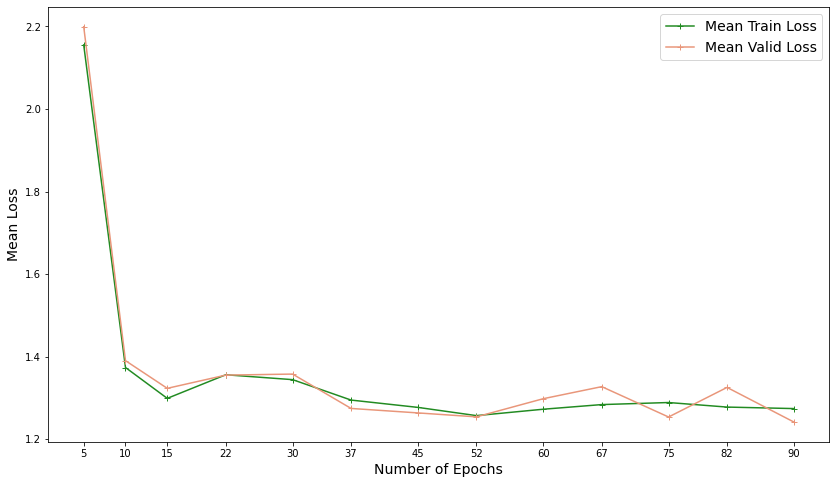

In [0]:
fig, ax = plt.subplots(1,1, figsize=(14, 8))
plt.plot(savesToTest, trainLoss, label="Mean Train Loss", marker="+", color="forestgreen")
plt.plot(savesToTest, valLoss, label="Mean Valid Loss", marker="+", color="darksalmon")
plt.ylabel("Mean Loss", fontsize=14)
plt.xlabel("Number of Epochs", fontsize=14)
plt.xticks(savesToTest)
plt.legend(fontsize=14)
plt.show()

In [0]:
X = pd.DataFrame((trainLoss, valLoss), columns=savesToTest)
X.to_csv(savefolder+"_expermiment_train_val_loss_1.csv")